<a href="https://colab.research.google.com/github/dsaldana/reinforcement-learning-course/blob/main/lab4_dyna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: TD and Dyna




## Exercise 1: Implement SARSA with n-step TD (n=5) on CliffWalking

**Objective:**  
In this exercise, you will implement the **SARSA algorithm** using **n-step temporal-difference learning with n=5**. You will apply your implementation to the **CliffWalking environment** in Gymnasium, and analyze how multi-step returns influence learning compared to standard 1-step SARSA.

---

### Environment
- Use `CliffWalking-v1`

---

### Instructions
1. Implement **SARSA with n-step TD updates (n=5)**:
   - Maintain an action-value table \(Q(s,a)\).
   - Use ε-greedy exploration.
   - Store states, actions, and rewards for the last 5 steps.
   - After each step, compute the n-step return: G_t
   - Update \(Q(s_t,a_t)\) toward \(G_t\).

2. Train your agent for several thousand episodes (e.g., 5,000).

3. Plot the **episode rewards over time** to visualize learning progress.

4. Compare qualitatively with 1-step SARSA:
   - Does n-step SARSA converge faster or slower?
   - How do the policies differ near the cliff?

---

### Deliverables
- Python code implementing SARSA with TD(5) (notebook in Github).  
- A plot of episode number vs episode return (plot in a cell below).  
- A short discussion (1 paragraph) comparing the results with standard SARSA.  


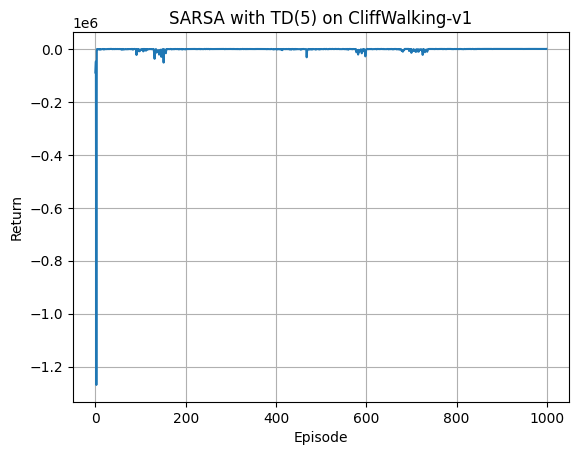

In [13]:
"""
SARSA with n-step TD (n=5) on CliffWalking-v1
"""

import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

# ----- Environment -----
env = gym.make("CliffWalking-v1")

# ----- Hyperparameters -----
alpha   = 0.1      # learning rate
gamma   = 0.99     # discount
epsilon = 0.1      # epsilon-greedy
n_step  = 5        # TD(n)
n_episodes = 1000
seed = 0
np.random.seed(seed)

n_states  = env.observation_space.n
n_actions = env.action_space.n

# ----- Q-table -----
Q = np.zeros((n_states, n_actions), dtype=np.float32)

def epsilon_greedy(state):
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    return int(np.argmax(Q[state]))

episode_returns = []

for ep in range(n_episodes):
    state, _ = env.reset(seed=seed + ep)

    # Sutton & Barto alignment:
    # states[0] = S0, actions[0] = A0, rewards[1] = R1, ...
    states  = [state]
    actions = [epsilon_greedy(state)]
    rewards = [0.0]  # dummy at index 0 so that rewards[t] = R_t

    T = float("inf")
    t = 0

    while True:
        if t < T:
            # take action A_t, observe R_{t+1}, S_{t+1}
            next_state, r, terminated, truncated, _ = env.step(actions[t])
            done = terminated or truncated

            rewards.append(r)
            states.append(next_state)

            if done:
                T = t + 1
            else:
                # choose A_{t+1} with epsilon-greedy and append so actions[t+1] exists
                actions.append(epsilon_greedy(next_state))

        tau = t - n_step + 1
        if tau >= 0:
            # ----- n-step return -----
            G = 0.0

            # upper = min(tau+n, T), but T can be inf and we may not yet have n rewards
            if np.isinf(T):
                upper = tau + n_step
            else:
                upper = min(tau + n_step, int(T))

            # also cap by what we actually have: rewards[k] exists for k <= len(rewards)-1
            upper = min(upper, len(rewards) - 1)

            # sum_{k=tau+1}^{upper} gamma^{k - tau - 1} * R_k
            for k in range(tau + 1, upper + 1):
                G += (gamma ** (k - tau - 1)) * rewards[k]

            # bootstrap term only if tau+n < T (and T is finite) AND we already have that (s,a)
            if (not np.isinf(T)) and (tau + n_step < T) and (tau + n_step < len(states)) and (tau + n_step < len(actions)):
                s_tau_n = states[tau + n_step]
                a_tau_n = actions[tau + n_step]
                G += (gamma ** n_step) * Q[s_tau_n, a_tau_n]

            # TD update
            s_tau = states[tau]
            a_tau = actions[tau]
            Q[s_tau, a_tau] += alpha * (G - Q[s_tau, a_tau])

        # stop when we've backed up the last state-action
        if (not np.isinf(T)) and (tau == T - 1):
            break


        t += 1

    episode_returns.append(sum(rewards[1:]))

# ----- Plot learning curve -----
plt.plot(episode_returns)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("SARSA with TD(5) on CliffWalking-v1")
plt.grid()
plt.show()


## Exercise 2: Dyna-Q for CliffWalking

**Objective**  
Implement **Dyna-Q** on **CliffWalking-v1** and compare its learning performance to **SARSA (1-step)** and **SARSA TD(5)**. You will analyze sample efficiency, stability near the cliff, and sensitivity to planning steps.

---

### Environment
- Use `CliffWalking-v1`
---

### Part A — Dyna-Q (Implementation)
1. **Q-table**: maintain `Q[s, a]` (tabular).
2. **Model**: learn an empirical model from experience.
   - For each observed transition `(s, a, r, s')`, update a dictionary:
     - Minimal: store the most recent `(s', r)` for `(s, a)`, **or**
     - Advanced: store a **multiset** of outcomes for `(s, a)` with counts (to sample stochastically).
3. **Real update (Q-learning)** after each env step:
   Q(s,a) ← Q(s,a) + α * (r + γ * max_a' Q(s',a') - Q(s,a))
4. **Planning updates**: after each real step, perform `N` simulated updates:
   - Sample a previously seen `(s_p, a_p)` from the model.
   - Sample `(r_p, s'_p)` from that entry.
   - Apply the same Q-learning backup using `(s_p, a_p, r_p, s'_p)`.
5. Use epsilon-greedy exploration.

---

### Part B — Baselines (Re-use / Implement)
- **SARSA (1-step)** with ε-greedy:
  \[
  Q(s,a) \leftarrow Q(s,a) + \alpha\big[r + \gamma Q(s',a') - Q(s,a)\big]
  \]
- **SARSA TD(5)** (n-step SARSA with \(n=5\)), as in Exercise 1.

Use the **same** γ, α, ε schedule, and number of episodes for a fair comparison.

---

### Part C — Experiments & Comparisons
1. **Learning curves**: plot **episode index vs. episode return** for:
   - Dyna-Q with \(N \in \{5, 20, 50\}\)
   - SARSA (1-step)
   - SARSA TD(5)
2. **Sample efficiency**: report the **episode number** at which the average return over a sliding window (e.g., 100 episodes) first exceeds a chosen threshold (e.g., −30).
3. **Stability near the cliff**: qualitatively inspect trajectories/policies; does the method hug the cliff or leave a safer margin?
4. **Sensitivity to planning steps**: compare Dyna-Q across N; discuss diminishing returns vs. computation.
5. **Statistical robustness**: run **≥5 seeds**; plot mean ± std (shaded) or report mean ± std of final returns.

---

### Deliverables
- **Code**: A driver script/notebook that reproduces your plots
- **Plots** (embedded in the notebook):
  - Learning curves (mean ± std across seeds)
  - Optional: heatmap of greedy policy/actions on the grid




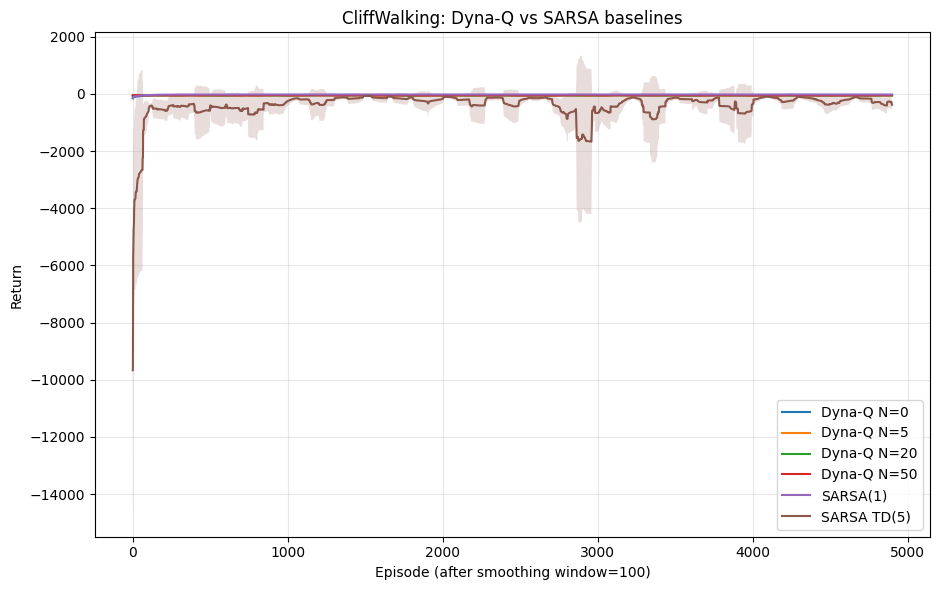


Sample efficiency (first episode where 100-ep moving average ≥ -30):
  Dyna-Q N=0: mean 4127 ± 1550  (seeds reaching threshold: 5/5)
  Dyna-Q N=5: mean 3657 ± 1839  (seeds reaching threshold: 5/5)
 Dyna-Q N=20: mean 4902 ± 0  (seeds reaching threshold: 5/5)
 Dyna-Q N=50: mean 4902 ± 0  (seeds reaching threshold: 5/5)
    SARSA(1): mean 262 ± 22  (seeds reaching threshold: 5/5)
 SARSA TD(5): mean 4902 ± 0  (seeds reaching threshold: 5/5)


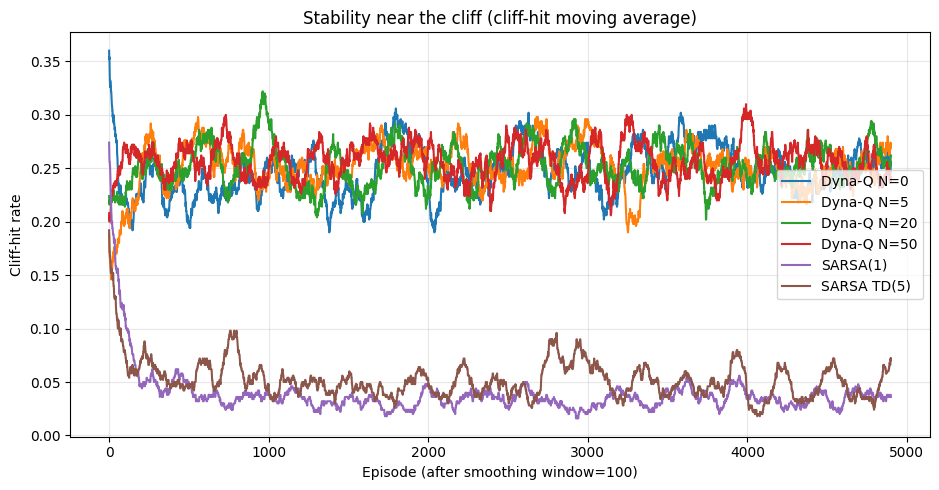

In [11]:
# Dyna-Q vs SARSA(1) vs SARSA TD(5) on CliffWalking-v1
# Gymnasium >= 0.28 API (step -> (obs, reward, terminated, truncated, info))
import numpy as np
import gymnasium as gym
from collections import deque, defaultdict
import matplotlib.pyplot as plt

# ------------------------- utils -------------------------
def make_env():
    return gym.make("CliffWalking-v1")

def epsilon_greedy(Q, s, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(Q.shape[1])
    # tie-breaking: choose randomly among best
    row = Q[s]
    best = np.flatnonzero(row == row.max())
    return int(np.random.choice(best))

def moving_average(x, w=100):
    if len(x) < w:
        return np.array([])
    filt = np.ones(w, dtype=float) / w
    return np.convolve(x, filt, mode="valid")

def first_crossing(mavg, threshold):
    idx = np.where(mavg >= threshold)[0]
    return None if len(idx) == 0 else int(idx[0])

# ------------------------- SARSA(1) -------------------------
def sarsa_one_step(n_episodes=5000, alpha=0.1, gamma=0.99, epsilon=0.1, seed=0):
    env = make_env()
    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA), dtype=np.float32)

    episode_returns = []
    cliff_hits = []
    for ep in range(n_episodes):
        s, _ = env.reset(seed=seed + ep)
        a = epsilon_greedy(Q, s, epsilon)
        done = False
        G = 0.0
        fell = False
        while not done:
            s2, r, term, trunc, _ = env.step(a)
            done = term or trunc
            G += r
            if r <= -100:   # fell into cliff
                fell = True
            if not done:
                a2 = epsilon_greedy(Q, s2, epsilon)
                td_target = r + gamma * Q[s2, a2]
            else:
                a2 = None
                td_target = r
            Q[s, a] += alpha * (td_target - Q[s, a])
            s, a = s2, (a2 if a2 is not None else 0)

        episode_returns.append(G)
        cliff_hits.append(int(fell))

    env.close()
    return Q, np.array(episode_returns), np.array(cliff_hits)

# ------------------------- SARSA n-step (TD(n)) -------------------------
def sarsa_n_step(n_step=5, n_episodes=5000, alpha=0.1, gamma=0.99, epsilon=0.1, seed=0):
    assert n_step >= 1
    env = make_env()
    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA), dtype=np.float32)

    episode_returns = []
    cliff_hits = []
    for ep in range(n_episodes):
        s0, _ = env.reset(seed=seed + ep)
        states  = [s0]
        actions = [epsilon_greedy(Q, s0, epsilon)]
        rewards = [0.0]  # rewards[1] will be R1
        T = float("inf")
        t = 0
        fell = False

        while True:
            if t < T:
                s_next, r, term, trunc, _ = env.step(actions[t])
                done = term or trunc
                rewards.append(r)
                states.append(s_next)
                if r <= -100:
                    fell = True
                if done:
                    T = t + 1
                else:
                    actions.append(epsilon_greedy(Q, s_next, epsilon))

            tau = t - n_step + 1
            if tau >= 0:
                # G = sum_{k=tau+1}^{min(tau+n, T)} gamma^{k - tau - 1} R_k
                if np.isinf(T):
                    upper = tau + n_step
                else:
                    upper = min(tau + n_step, int(T))
                upper = min(upper, len(rewards) - 1)

                G = 0.0
                for k in range(tau + 1, upper + 1):
                    G += (gamma ** (k - tau - 1)) * rewards[k]

                # bootstrap if tau + n < T
                if (not np.isinf(T)) and (tau + n_step < T) and (tau + n_step < len(states)) and (tau + n_step < len(actions)):
                    s_tau_n = states[tau + n_step]
                    a_tau_n = actions[tau + n_step]
                    G += (gamma ** n_step) * Q[s_tau_n, a_tau_n]

                s_tau, a_tau = states[tau], actions[tau]
                Q[s_tau, a_tau] += alpha * (G - Q[s_tau, a_tau])

            if (not np.isinf(T)) and (tau == T - 1):
                break

            t += 1

        episode_returns.append(sum(rewards[1:]))
        cliff_hits.append(int(fell))

    env.close()
    return Q, np.array(episode_returns), np.array(cliff_hits)

# ------------------------- Dyna-Q -------------------------
def dyna_q(n_planning=20, n_episodes=5000, alpha=0.1, gamma=0.99, epsilon=0.1,
           seed=0, per_sa_capacity=50):
    """
    Dyna-Q with a simple stochastic model:
      model[(s,a)] -> deque([(r, s_next, done), ...])
    Planning uses Q-learning backups on simulated one-step transitions.
    """
    env = make_env()
    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA), dtype=np.float32)

    model = defaultdict(lambda: deque(maxlen=per_sa_capacity))
    sa_keys = []  # list of seen (s,a) for uniform sampling

    episode_returns = []
    cliff_hits = []

    rng = np.random.RandomState(seed)

    for ep in range(n_episodes):
        s, _ = env.reset(seed=seed + ep)
        done = False
        G = 0.0
        fell = False

        while not done:
            a = epsilon_greedy(Q, s, epsilon)
            s2, r, term, trunc, _ = env.step(a)
            done = term or trunc
            G += r
            if r <= -100:
                fell = True

            # Real Q-learning update
            td_target = r if done else (r + gamma * np.max(Q[s2]))
            Q[s, a] += alpha * (td_target - Q[s, a])

            # Update model
            key = (s, a)
            if key not in model:
                sa_keys.append(key)
            model[key].append((r, s2, done))

            # Planning updates
            for _ in range(n_planning):
                sp, ap = sa_keys[rng.randint(len(sa_keys))]
                r_p, s_p_next, done_p = model[(sp, ap)][rng.randint(len(model[(sp, ap)]))]
                target_p = r_p if done_p else (r_p + gamma * np.max(Q[s_p_next]))
                Q[sp, ap] += alpha * (target_p - Q[sp, ap])

            s = s2

        episode_returns.append(G)
        cliff_hits.append(int(fell))

    env.close()
    return Q, np.array(episode_returns), np.array(cliff_hits)

# ------------------------- experiment harness -------------------------
def run_many(method_fn, seeds, **kwargs):
    all_returns = []
    all_cliffs  = []
    for sd in seeds:
        _, rets, cliffs = method_fn(seed=sd, **kwargs)
        all_returns.append(rets)
        all_cliffs.append(cliffs)
    return np.stack(all_returns, 0), np.stack(all_cliffs, 0)  # [n_seeds, n_episodes]

def plot_learning_curves(curves_dict, smooth=100, title="Learning curves"):
    plt.figure(figsize=(9.5, 6))
    for label, returns in curves_dict.items():
        # returns: [n_seeds, n_episodes]
        mavg = np.array([moving_average(ret, smooth) for ret in returns])
        mean = mavg.mean(axis=0)
        std  = mavg.std(axis=0)
        xs = np.arange(len(mean))
        plt.plot(xs, mean, label=label)
        plt.fill_between(xs, mean - std, mean + std, alpha=0.2)
    plt.xlabel(f"Episode (after smoothing window={smooth})")
    plt.ylabel("Return")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def report_sample_efficiency(curves_dict, threshold=-30, smooth=100):
    print(f"\nSample efficiency (first episode where {smooth}-ep moving average ≥ {threshold}):")
    for label, returns in curves_dict.items():
        crossings = []
        for ret in returns:
            mavg = moving_average(ret, smooth)
            idx = first_crossing(mavg, threshold)
            crossings.append(len(mavg) + 1 if idx is None else (idx + smooth))  # map to original ep index
        crossings = np.array(crossings)
        ok = crossings < (len(returns[0]) + 1)
        msg = f"{label:>12}: mean {crossings.mean():.0f} ± {crossings.std():.0f}  (seeds reaching threshold: {ok.sum()}/{len(crossings)})"
        print(msg)

def plot_cliff_hits(cliff_dict, window=100, title="Cliff falls per episode (moving average)"):
    plt.figure(figsize=(9.5, 5))
    for label, cliffs in cliff_dict.items():
        # cliffs: [n_seeds, n_episodes] of 0/1
        mavg = np.array([moving_average(c, window) for c in cliffs]).mean(axis=0)
        plt.plot(np.arange(len(mavg)), mavg, label=label)
    plt.xlabel(f"Episode (after smoothing window={window})")
    plt.ylabel("Cliff-hit rate")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# ------------------------- run the study -------------------------
if __name__ == "__main__":
    n_episodes = 5000
    alpha = 0.1
    gamma = 0.99
    epsilon = 0.1
    seeds = [0, 1, 2, 3, 4]  # ≥5 seeds as requested

    # Dyna-Q with different planning steps
    dyna_configs = [0, 5, 20, 50]  # N=0 is plain Q-learning (no planning)
    dyna_returns = {}
    dyna_cliffs  = {}
    for N in dyna_configs:
        rets, cliffs = run_many(
            dyna_q, seeds,
            n_planning=N, n_episodes=n_episodes, alpha=alpha, gamma=gamma, epsilon=epsilon
        )
        dyna_returns[f"Dyna-Q N={N}"] = rets
        dyna_cliffs[f"Dyna-Q N={N}"]  = cliffs

    # Baselines: SARSA(1) and SARSA TD(5)
    s1_rets, s1_cliffs = run_many(
        sarsa_one_step, seeds,
        n_episodes=n_episodes, alpha=alpha, gamma=gamma, epsilon=epsilon
    )
    s5_rets, s5_cliffs = run_many(
        sarsa_n_step, seeds,
        n_step=5, n_episodes=n_episodes, alpha=alpha, gamma=gamma, epsilon=epsilon
    )

    # Combine results for plots/reports
    curves = {**dyna_returns, "SARSA(1)": s1_rets, "SARSA TD(5)": s5_rets}
    cliffs = {**dyna_cliffs,  "SARSA(1)": s1_cliffs, "SARSA TD(5)": s5_cliffs}

    # Learning curves (mean ± std across seeds)
    plot_learning_curves(curves, smooth=100, title="CliffWalking: Dyna-Q vs SARSA baselines")

    # Sample efficiency
    report_sample_efficiency(curves, threshold=-30, smooth=100)

    # Stability near the cliff (fewer falls is better)
    plot_cliff_hits(cliffs, window=100, title="Stability near the cliff (cliff-hit moving average)")


## Exercise 3: Solve FrozenLake with Q-Learning and Dyna-Q (Stochastic Model)

**Objective**  
Implement and compare **Q-learning** and **Dyna-Q** on Gymnasium’s `FrozenLake-v1`.  
For Dyna-Q, your learned **transition model must handle multiple possible next states** per `(s, a)` (stochastic slip), i.e., store and sample **a distribution** over `(s', r)` outcomes rather than a single next state.

---

### Environment
- Use `FrozenLake-v1` from `gymnasium.envs.toy_text`.
- You can start with map 4×4; and then work with 8×8.
- Start → Goal with slippery transitions (stochastic).  
- Rewards: `+1` at goal, `0` otherwise (holes terminate with 0).

---

### Part A — Q-learning (baseline)
1. Maintain a tabular action-value function `Q[s, a]`.
2. Behavior: ε-greedy over `Q`.
3. Update after each real step:
   - target = r + γ * max_a' Q[s', a']   (if terminal: target = r)
   - Q[s, a] ← Q[s, a] + α * (target − Q[s, a])
4. Train for several thousand episodes (e.g., 5,000) with an ε schedule (e.g., 0.2 → 0.01).

---

### Part B — Dyna-Q with a **stochastic transition model**
1. **Empirical model (multinomial):** for each `(s, a)`, maintain a multiset of observed outcomes:
   - `model[(s, a)] = [(s'_1, r_1, count_1), (s'_2, r_2, count_2), ...]`
   - Update counts whenever you observe `(s, a, r, s')`.
2. **Real step update (Q-learning):** same as Part A.
3. **Planning steps (N per real step):**
   - Sample a previously seen `(s_p, a_p)` uniformly (or with priority).
   - Sample `(s'_p, r_p)` **from the empirical distribution** for `(s_p, a_p)` using counts as probabilities.
   - Apply the same Q-learning backup with `(s_p, a_p, r_p, s'_p)`.
4. Train with the same ε schedule and number of episodes; vary `N ∈ {5, 20, 50}`.

---

### Experiments & Analysis
1. **Learning curves:** plot episode index vs episode return (smoothed) for:
   - Q-learning
   - Dyna-Q (N=5, 20, 50)
2. **Sample efficiency:** report the episode at which the moving-average return (e.g., window 100) first exceeds a threshold (you choose a reasonable value).
3. **Effect of stochastic modeling:** briefly explain why storing a distribution over `(s', r)` matters on FrozenLake (slip), and what happens if you store only the most recent outcome.
4. **Robustness:** run ≥5 random seeds; report mean ± std of final evaluation returns.

---

### Deliverables
- **Code** for Q-learning and Dyna-Q (with stochastic model).  
- **Plots** of learning curves (include legend and axis labels).  
- ** Discussion:** why Dyna-Q helps here; impact of N; importance of modeling multiple next states.

---

### Hints
- For terminal transitions (goal/hole), the Q-learning target is simply `target = r` (no bootstrap).  
- When sampling from the model, use probabilities `p_i = count_i / sum_j count_j`.  
- Tie-break greedy action selection uniformly among argmax actions to avoid bias.  
- Keep evaluation **greedy (ε=0)** and consistent across methods (same seeds and episode counts).
